# Final Project

# 1.1 Classification Problem --- White Blood Cells

## Dataset Description

The White Blood Cells dataset consists of 410 images, with 4 classes:  Eosinophil, Lymphocyte, Monocyte, and Neutrophil. Each of the images contains one White Blood Cells, surrounded by multiple red blood cells. The accompanying xml files contain bounding boxes for the segmentation of white blood cell images.

In the Blood Cell dataset, the raw data is images of multiple blood cells of size 640*480. For our classification purpose, we want to crop the exact white blood cell from each images. The Class of the White Cell does not depend on the context or the surrounding cells, so we crop the exact cell to reduce the data dimension.

For each of the images, the white blood cell is marked out by a corresponding .xml file. 

The label is given in a csv file, with a few entries left blank or having multiple classes. We eliminate these bad inputs and left with 356 valid data samples.

In [81]:
import csv
import numpy as np
import cv2
import glob, copy, os
import xml.etree.ElementTree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

## 1-1 Preprocessing By Shuyu Chen

## data pre-processing -- image related


We want to generate a source matrix from the input images. After cropping the image, we resize all the cropped images and flatten each them into a vector. 

A discussion can be drawn when dealing with the channel of the image. The raw images are colored RGB images. Since some structures of the White cells are represented primarily by color, we can argue that preserving the RGB information can be beneficial for feature extraction. Our design is to offer choices of channels. We define the preprocessing stage into a function, and make color channel as an argument. We can use full RGB channel, or use 1 of 3 channels (only red pixels, or green, or blue), or use the converted Gray channel. Using full RGB channel will augment the dimensionality of the source matrix by factor of 3.

In [67]:

class Reading(object):
    """__init__() functions as the class constructor"""
    def __init__(self, xmin=None, ymin=None, xmax=None, ymax=None, typ=None, name=None):
        """self.difficult = difficult
        self.truncated = truncated"""
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.typ = typ
        self.name = name

docs = sorted(glob.glob('BCCD_Dataset-master/BCCD/Annotations/' + '*.xml'))      

list_reading_arr = []
with open('BCCD_Dataset-master/labels.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    label_arr = []
    counter = 0
    for row in csv_reader:
        if counter != 0 and row[2] != "":
            label_arr.append([row[1], row[2]])
        #if :
        #   label_arr.append()
        counter += 1

index = 0
for i in range(len(docs)):
    label_this='B'
    #tree = xml.etree.ElementTree.parse('//dataset-master//Annotations//BloodImage_00000.xml')
    #print(doc + " " + label_arr[index][1])
    if(int(label_arr[index][0]) == int(docs[i][-9:-4])):
        label_this = label_arr[index][1][0]
    
    else:
        if(int(label_arr[index-1][0]) == int(docs[i][-9:-4])):
            #print('-1')
            #print(docs[i][-9:-4])
            #print(label_this)
            index += -1
            i+=-1
            label_this = label_arr[index][1][0]
        if(int(label_arr[index+1][0]) == int(docs[i][-9:-4])):
            #print('+1')
            #print(docs[i][-9:-4])
            #print(label_this)
            label_this = label_arr[index+1][1][0]
            #i+=1
            index += 1
    
    if(label_this == 'B'):
        index += 1
        #i+=1
        #print(docs[i])
        #docs.remove(doc)
        continue
    if(label_this == ''):
        index += 1
        #i+=1
        #print(docs[i])
        #docs.remove(doc)
        continue
    """"""   
    tree = xml.etree.ElementTree.parse(docs[i])
    root = tree.getroot()
    len_data = int(len(tree.findall('.//object//'))/9)
    #list_reading = [Reading() for i in range(len_data)]
    read = Reading()
    #print(doc)
   
            #continue
    #print(doc + label_this)
    count = 0
    #print("Print out the attrib of the root:\n")
    #list_reading[index_of_reading].typ = label_this
    #list_reading[index_of_reading].name = docs[i]
    read.typ = label_this
    read.name = docs[i]
    for objs in tree.findall('.//object//'):
        index_of_reading = int(count/9)
        #if(list_reading[index_of_reading])
        """if count%9 == 2:
            list_reading[index_of_reading].truncated = int(objs.text)
        if count%9 == 3:
            list_reading[index_of_reading].difficult = int(objs.text)"""
        #print(objs.text)
        
        if count%9 == 0:
            if objs.text != "WBC":
                #print("NO WBC")
                continue
        if count%9 == 5:
            #list_reading[index_of_reading].xmin = int(objs.text)
            read.xmin = int(objs.text)
        if count%9 == 6:
            #list_reading[index_of_reading].ymin = int(objs.text)
            read.ymin = int(objs.text)
        if count%9 == 7:
            #list_reading[index_of_reading].xmax = int(objs.text)
            read.xmax = int(objs.text)
        if count%9 == 8:
            #list_reading[index_of_reading].ymax = int(objs.text)
            read.ymax = int(objs.text)
             
        
        count+=1
    
    #print(docs[i] + label_this)
    list_reading_arr.append(read)
    for j in list_reading_arr:
        if j.xmax == j.xmin or j.ymax == j.ymin:
            #print(doc)
            list_reading_arr.remove(j)
        #print("cordinates:",i.xmin,i.ymin,i.xmax,i.ymax)
    index += 1
    
    
#print(list_reading_arr[0][0].xmin)

    

0.95 explained variance ratio can be achieved using at least 109 principle components


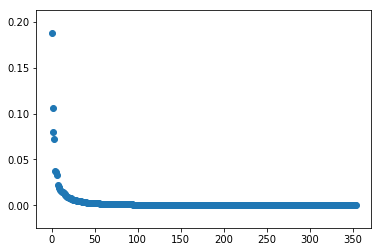

0.95 explained variance ratio can be achieved using at least 191 principle components


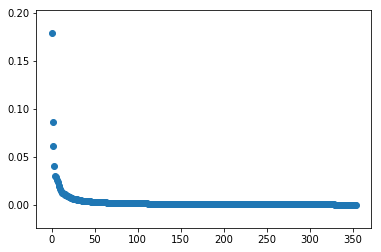

0.95 explained variance ratio can be achieved using at least 109 principle components


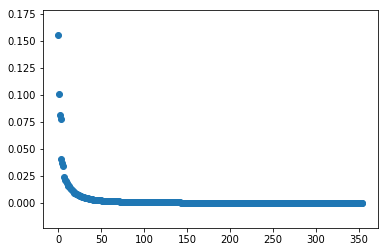

0.95 explained variance ratio can be achieved using at least 115 principle components


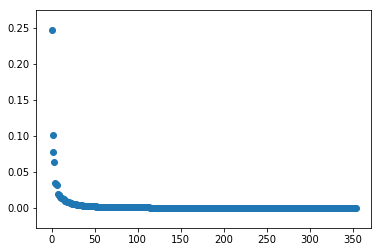

In [74]:
def crop_and_resize(img, read, size):
    w, h = size
    
    img_arr =[]
    xmin, ymin, xmax, ymax = (read.xmin,read.ymin,read.xmax,read.ymax)
    #print([xmin, ymin, xmax, ymax])
    img_crop = img[ymin:ymax,xmin:xmax]
    img_resized = cv2.resize(img_crop,(w, h), interpolation = cv2.INTER_CUBIC)
    img_arr.append(img_resized)

    return img_arr

def label_generator(read):
    if(read=='N'):
        return 0
    if(read=='M'):
        return 1
    if(read=='L'):
        return 2
    if(read=='E'):
        return 3
    
def recenter_regularize(X):
    X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_centered = X - X_mean.T
    X_norm = np.linalg.norm(X_centered, axis = 1)[np.newaxis]
    X_normalized = X_centered/X_norm.T
    return X_normalized



path = 'BCCD_Dataset-master\\BCCD\\JPEGImages\\'
#images = sorted(glob.glob(path + '*.jpg'))
WBC_arr_b = []; WBC_arr_g = []; WBC_arr_r = []; WBC_arr_gray = []
label_arr = []
#read images and make each into an array
for i in range(len(list_reading_arr)):
    img = path + os.path.split(list_reading_arr[i].name)[1][:-4] + '.jpg'
    WBC_this = cv2.imread(img)
    WBC_this_arr = crop_and_resize(WBC_this, list_reading_arr[i], (60,60))
    WBC_b = WBC_this_arr[0][:, :, 0]
    WBC_g = WBC_this_arr[0][:, :, 1]
    WBC_r = WBC_this_arr[0][:, :, 2]
    WBC_gray = cv2.cvtColor(WBC_this_arr[0], cv2.COLOR_BGR2GRAY)
    

    label = label_generator(list_reading_arr[i].typ)
    #label = list_reading_arr[i]
    #print(label)

    WBC_b, WBC_g, WBC_r, WBC_gray = np.reshape(WBC_b, -1), np.reshape(WBC_g, -1), np.reshape(WBC_r, -1), np.reshape(WBC_gray, -1)
    
    
    WBC_arr_b.append(WBC_b)
    WBC_arr_g.append(WBC_g)
    WBC_arr_r.append(WBC_r)
    WBC_arr_gray.append(WBC_gray)
    label_arr.append(label)
        
        
    i+=1
    if(i==len(list_reading_arr)):
        break
WBC_arr_b, WBC_arr_g, WBC_arr_r, WBC_arr_gray = (np.asarray(WBC_arr_b).T, np.asarray(WBC_arr_g).T, 
                                                 np.asarray(WBC_arr_r).T, np.asarray(WBC_arr_gray).T)

(WBC_normalized_b, WBC_normalized_g, WBC_normalized_r, 
 WBC_normalized_gray) = (recenter_regularize(WBC_arr_b), recenter_regularize(WBC_arr_g),
                         recenter_regularize(WBC_arr_r), recenter_regularize(WBC_arr_gray)) 

def getComponents(DataNormalized):
    U, S, V = np.linalg.svd(DataNormalized)

    S_total = np.linalg.norm(S)**2
    S_incr = 0
    k = 0
    for s in S:
        S_incr += s**2
        if(S_incr >= 0.95*S_total):
            break
        k += 1

    print('0.95 explained variance ratio can be achieved using at least ' + str(k) + ' principle components')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(range(len(S)), S**2/S_total)
    plt.show()
    return U, k

U_gray, k_gray = getComponents(WBC_normalized_gray)
U_b, k_b = getComponents(WBC_normalized_b)
U_g, k_g = getComponents(WBC_normalized_g)
U_r, k_r = getComponents(WBC_normalized_r)




## data pre-processing --- PCA

In [76]:
#Principle components
U_k = []
for i in range(k_gray):
    U_k.append(U_gray[:, i])
    
U_k = np.asarray(U_k)   
WBC_tilta_gray = []
for WBC in WBC_normalized_gray.T:
    WBC_tilta_gray.append(list(map(lambda x:np.inner(x, WBC), U_k.tolist())))
    



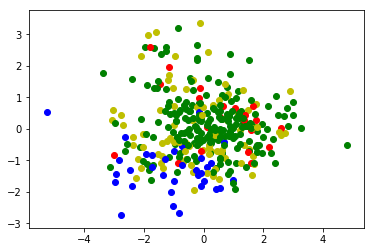

In [78]:
#RBC_tilta_list = copy.deepcopy(RBC_tilta)
WBC_tilta_gray = np.asarray(WBC_tilta_gray).T
WBC_tilta_gray_12 = WBC_tilta_gray[:2]
WBC_tilta_gray_1 = WBC_tilta_gray[0]


fig = plt.figure()
ax = fig.add_subplot(111)
WBC_tilta_gray_12 = WBC_tilta_gray_12.T
counter = 0
for i in range(len(WBC_tilta_gray_12)):
    if(label_arr[i] == 0):
        c = 'g'
    if(label_arr[i] == 1):
        c = 'r'
    if(label_arr[i] == 2):
        counter += 1
        c = 'b'
    if(label_arr[i] == 3):
        c = 'y'
        
    ax.scatter(WBC_tilta_gray_12[i][0], WBC_tilta_gray_12[i][1], color = c)

plt.show()


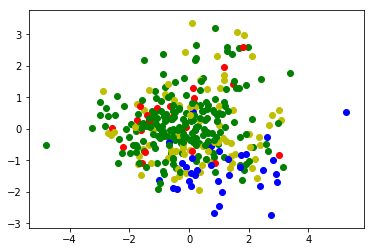

In [77]:
#compare with sklearn PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(WBC_normalized_gray.T)
print(pca.explained_variance_ratio_)
print(pca.components_)


U_skPCA = pca.components_

U_skPCA = np.asarray(U_skPCA)
WBC_tilta_gray_sk = []

for WBC in WBC_normalized_gray.T:
    WBC_tilta_gray_sk.append(list(map(lambda x:np.inner(x, WBC), U_skPCA)))
    
fig = plt.figure()
ax = fig.add_subplot(111)
WBC_tilta_gray_sk = np.asarray(WBC_tilta_gray_sk)
counter = 0
for i in range(len(WBC_tilta_gray_sk)):
    if(label_arr[i] == 0):
        c = 'g'
    if(label_arr[i] == 1):
        c = 'r'
    if(label_arr[i] == 2):
        counter += 1
        c = 'b'
    if(label_arr[i] == 3):
        c = 'y'
        
    ax.scatter(WBC_tilta_gray_sk[i][0], WBC_tilta_gray_sk[i][1], color = c)

plt.show()

## 1-2 knn approach by shuyu chen

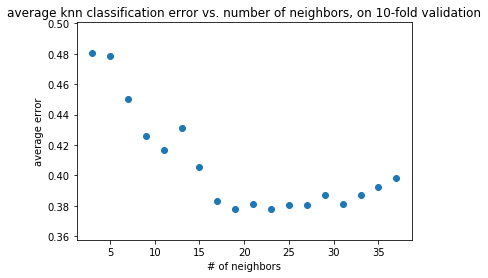

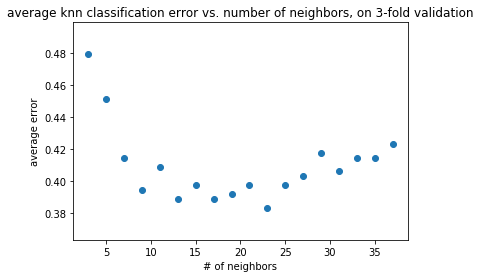

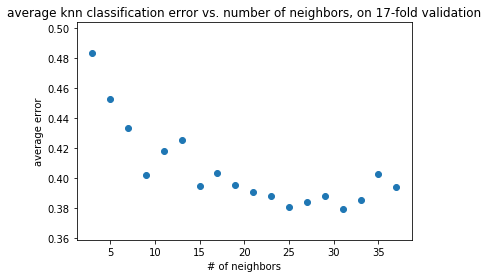

'        \nWBC_tilta_gray_train = WBC_tilta_gray[:, :300]\nWBC_tilta_gray_test = WBC_tilta_gray[:, 300:]\n\n\n#for k in range()\nfor i in range(len(WBC_tilta_gray_test[0])):\n    \n    cls.append(KNN_classif(WBC_tilta_gray_test[:,i], WBC_tilta_gray_train , label_arr, 19))\n\ncls = np.asarray(cls)\nprint(cls-np.asarray(label_arr[300:]))\n#print(np.sum(cls - np.asarray(label_arr[3000:])))\n#RBC_tilta = np.asarray(RBC_tilta_list).T\n\n'

In [79]:

# KNN classifier
#img_Rep is M*N, Feature of length M, trainLabels of length N

def KNN_classif(Feature, img_Rep, trainLabels, k):
    #training_labels = np.asarray(trainLabels)
    #compute the distance of the input N-dim Feature to every other point
    #
    distance=[]
    for img in img_Rep.T:
        distance.append(np.linalg.norm(img - Feature))
    
    distance = np.array(distance)
    distance_k = distance.argsort()[:k]
    trainLabels = np.asarray(trainLabels)
    neighbors = trainLabels[distance_k].tolist()
    #print(neighbors)
    #x = np.sum(training_labels[distance_k])
    #return x
    return max(neighbors, key=neighbors.count)

# k-fold Cross Validation 
# k-fold Cross Validation 
def cross_validation(samples, labels, numFold:int, k:int):
    #print(samples.shape)
    #print(labels.shape)
    m,n = np.shape(samples)
    samples_with_labels = np.row_stack((samples, labels))
    a = n//numFold
    #print(a)
    fold = [0 for i in range(numFold)]
    for i in range(numFold):
        if i!= numFold-1:
            fold[i] = samples_with_labels[:, i*a:(i+1)*a]
        else:
            fold[i] = samples_with_labels[:, i*a:]
    
    #reg_error = [0 for i in range(numFold)]
    knn_error = [0 for i in range(numFold)]
    for i in range(numFold):
        training_samples_w_labels = []
        for j in range(numFold):
            if j==i: 
                test_samples = fold[j][:-1, :]
                test_labels = fold[j][-1,:]
                #print(test_samples)
                #print(fold[i].shape)
            else:
                training_samples_w_labels.append(fold[j])
        training_samples_w_labels = np.hstack(training_samples_w_labels)
        training_samples = training_samples_w_labels[:-1, :]
        training_labels = training_samples_w_labels[-1, :]
        #print(len(training_labels))
        cls = []
        for j in range(len(test_samples[0])):
            #print(test_samples.shape)
            #print(training_samples.shape)
            cls.append(KNN_classif(test_samples[:, j], training_samples, training_labels, k))            
        cls = np.asarray(cls)
        knn_error[i] = sum(cls-test_labels != 0)/len(test_labels)
        #print('pair')
        #print(cls)
        #print(test_labels)
    return np.mean(knn_error)
        
#Learn the Best K

knn_error_avg_arr = []

for k in range(3, 39, 2):
    knn_error_avg = cross_validation(WBC_tilta_gray, np.asarray(label_arr), 10, k)
    knn_error_avg_arr.append(knn_error_avg)
    
plt.figure()
plt.scatter(range(3,39,2), knn_error_avg_arr)
plt.title('average knn classification error vs. number of neighbors, on 10-fold validation')
plt.xlabel('# of neighbors')
plt.ylabel('average error')
plt.show()

knn_error_avg_arr = []
for k in range(3, 39, 2):
    knn_error_avg = cross_validation(WBC_tilta_gray, np.asarray(label_arr), 3, k)
    knn_error_avg_arr.append(knn_error_avg)
    
plt.figure()
plt.scatter(range(3,39,2), knn_error_avg_arr)
plt.title('average knn classification error vs. number of neighbors, on 3-fold validation')
plt.xlabel('# of neighbors')
plt.ylabel('average error')
plt.show()

knn_error_avg_arr = []
for k in range(3, 39, 2):
    knn_error_avg = cross_validation(WBC_tilta_gray, np.asarray(label_arr), 17, k)
    knn_error_avg_arr.append(knn_error_avg)
    
plt.figure()
plt.scatter(range(3,39,2), knn_error_avg_arr)
plt.title('average knn classification error vs. number of neighbors, on 17-fold validation')
plt.xlabel('# of neighbors')
plt.ylabel('average error')
plt.show()
"""        
WBC_tilta_gray_train = WBC_tilta_gray[:, :300]
WBC_tilta_gray_test = WBC_tilta_gray[:, 300:]


#for k in range()
for i in range(len(WBC_tilta_gray_test[0])):
    
    cls.append(KNN_classif(WBC_tilta_gray_test[:,i], WBC_tilta_gray_train , label_arr, 19))

cls = np.asarray(cls)
print(cls-np.asarray(label_arr[300:]))
#print(np.sum(cls - np.asarray(label_arr[3000:])))
#RBC_tilta = np.asarray(RBC_tilta_list).T

"""        






We can determine the optimum parameter for KNN algorithm through cross validation. We can see that the average error not only changes with the number of neighbors, but also varies with the number of folds in cross validation setting. By trying very odd integer from 3 to 37 for k, with number of folds being 3, 10 or 17, we can see that average error is lower, across number of folds, when k is chosen between 17 to 27. Number of folds has substantial effect on how error rate changes with k. A general trend is that, the range of k value for lower error rate shifts to right, as number of folds increases. If we decide that the number of folds is 10, then the best k is 19. 

Confusion matrix, without normalization


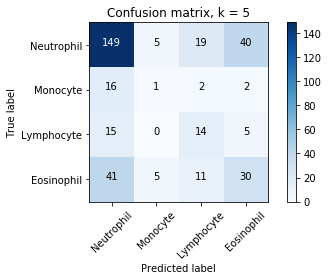

Confusion matrix, without normalization


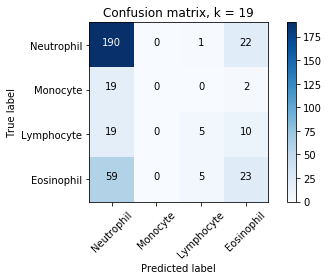

Confusion matrix, without normalization


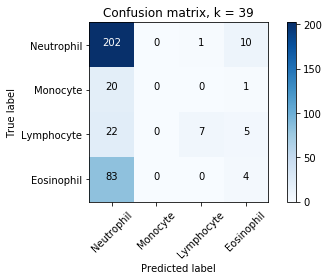

In [82]:
def test_on_whole_set(samples, labels, numFold, k):
    m,n = np.shape(samples)
    samples_with_labels = np.row_stack((samples, labels))
    a = n//numFold
    cls = []
    #print(a)
    fold = [0 for i in range(numFold)]
    for i in range(numFold):
        if i!= numFold-1:
            fold[i] = samples_with_labels[:, i*a:(i+1)*a]
        else:
            fold[i] = samples_with_labels[:, i*a:]
    
    #reg_error = [0 for i in range(numFold)]
    knn_error = [0 for i in range(numFold)]
    test_labels_total = []
    for i in range(numFold):
        training_samples_w_labels = []
        for j in range(numFold):
            if j==i: 
                test_samples = fold[j][:-1, :]
                test_labels = fold[j][-1,:]
                #print(test_samples)
                #print(fold[i].shape)
            else:
                training_samples_w_labels.append(fold[j])
        training_samples_w_labels = np.hstack(training_samples_w_labels)
        training_samples = training_samples_w_labels[:-1, :]
        training_labels = training_samples_w_labels[-1, :]
        test_labels_total.append(test_labels)
        #print(len(training_labels))
        #cls = []
        for j in range(len(test_samples[0])):
            #print(test_samples.shape)
            #print(training_samples.shape)
            cls.append(KNN_classif(test_samples[:, j], training_samples, training_labels, k))
    test_labels_total = np.hstack(test_labels_total)
    return cls, test_labels_total
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
WBC_classes = {'Neutrophil': 0, 'Monocyte': 1, 'Lymphocyte': 2, 'Eosinophil': 3}

pred_total, test_labels_total = test_on_whole_set(WBC_normalized_gray, label_arr, 10, 5)
cm = confusion_matrix(test_labels_total, pred_total)
plot_confusion_matrix(cm, 
                      classes = list(map(lambda x:x[0], sorted(WBC_classes.items(), key = lambda t:t[1]))),
                      title = 'Confusion matrix, k = 5')
plt.show()
plt.figure()
pred_total, test_labels_total = test_on_whole_set(WBC_normalized_gray, label_arr, 10, 19)
cm = confusion_matrix(test_labels_total, pred_total)
plot_confusion_matrix(cm, 
                      classes = list(map(lambda x:x[0], sorted(WBC_classes.items(), key = lambda t:t[1]))),
                      title = 'Confusion matrix, k = 19')

plt.show()
plt.figure()
pred_total, test_labels_total = test_on_whole_set(WBC_normalized_gray, label_arr, 10, 39)
cm = confusion_matrix(test_labels_total, pred_total)
plot_confusion_matrix(cm, 
                      classes = list(map(lambda x:x[0], sorted(WBC_classes.items(), key = lambda t:t[1]))),
                      title = 'Confusion matrix, k = 39')


The confusion matrices show that the false positive rate for 'Neutrophil' class is very high. Many samples of 'M','L' and 'E' classes are predicted as 'N'. We need to observe that the described false positive rate grows as the number of neighbors (k) taken into account increases. Since the dataset is imbanlanced, with 'N' class samples being the majority, K-Nearest Neighbor algorithm may favor class 'N' in the majority voting stage. This conjecture is supported by the fact that increasing k from 5 to 19 controls the total error rate, but causes greater false positive rate with respect to 'N' class, and the accuracy for 'N', 'L' and 'E' classes actually decreases. The false positive rate becomes even higher when K=39, with most predictions being 'N'. 

We can infer that the KNN algorithm is not functioning properly when dealing with imbalanced data. Additional preprocessing technique or modification of the algorithm may alleviate this issue. However, it may be better to use algorithms that are robust to imbalanced data in the first place. One of those algorithms is the Random Forest algorithm.

## 1-3 Random Forest approach by Chaoji Zuo

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

In [84]:
labels=[]
for i in list_reading_arr:
      labels.append(i.typ)
X_all=WBC_normalized_gray.T
y_all=labels
print("value counts of labels:\n",pd.Series(y_all).value_counts())

value counts of labels:
 N    213
E     87
L     34
M     21
dtype: int64


### first try of whole data

like the regression problem, I applied the random forest on the whole data and test on it. It got a pretty great 
result

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


precision score : 0.9915492957746479
accuracy : 0.9915492957746479
Normalized confusion matrix


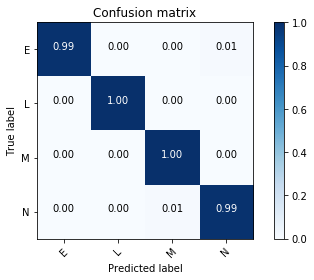

In [86]:
RFClassifier=RandomForestClassifier()
RFClassifier.fit(X_all,y_all)
pred_y=RFClassifier.predict(X_all)
print('precision score :',precision_score(y_pred=pred_y,y_true=y_all,average='micro'))
print('accuracy :',accuracy_score(y_pred=pred_y,y_true=y_all))
con_mat=confusion_matrix(pred_y,y_all)
plot_confusion_matrix(con_mat,classes=['E','L','M','N'],normalize=True)


In [87]:
raw_data=WBC_normalized_gray.T
raw_amount=np.array(labels)
import random
folds_data=[]
folds_labels=[]
def randomData(num):
    indexs=list(range(num))
    each=int(num/5)
    random.shuffle(indexs)
    data1=raw_data[indexs[:each]]
    y1=raw_amount[indexs[:each]]
    
    data2=raw_data[indexs[each:each*2]]
    y2=raw_amount[indexs[each:each*2]]
    
    data3=raw_data[indexs[each*2:each*3]]
    y3=raw_amount[indexs[each*2:each*3]]
    
    data4=raw_data[indexs[each*3:each*4]]
    y4=raw_amount[indexs[each*3:each*4]]
    
    data5=raw_data[indexs[each*4:each*5]]
    y5=raw_amount[indexs[each*4:each*5]]
    
    
    folds_data=[data1,data2,data3,data4,data5]
    folds_labels=[y1,y2,y3,y4,y5]
    return folds_data,folds_labels


        
fold_number=np.array([0,1,2,3,4])
folds_data,folds_labels=randomData(355)

### Cross-Validation on whole data

Then I split data into test set and training set and use cross validation to see its generalization ability

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


prediction error of fold  0  :  0.6619718309859155
Normalized confusion matrix


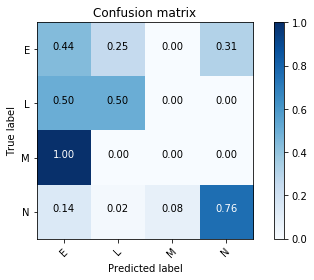

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


prediction error of fold  1  :  0.6619718309859155
Normalized confusion matrix


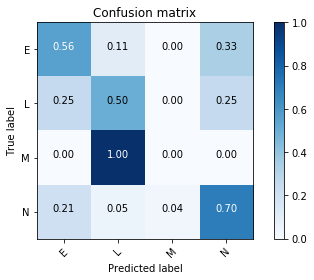

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


prediction error of fold  2  :  0.5492957746478874
Normalized confusion matrix


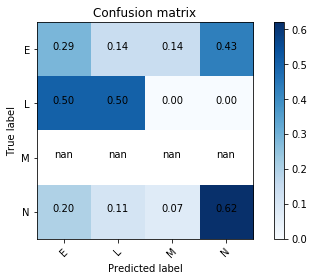

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


prediction error of fold  3  :  0.6619718309859155
Normalized confusion matrix


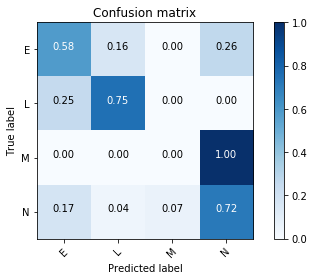

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


prediction error of fold  4  :  0.6338028169014085
Normalized confusion matrix


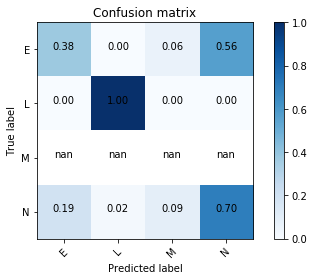

In [88]:
precisionArr=[]
recallArr=[]
for i in range(5):
    test_data=folds_data[i]
    test_labels=folds_labels[i]
    train_number=np.delete(fold_number,i,axis=0)
    train_data=np.concatenate((folds_data[train_number[0]],folds_data[train_number[1]],folds_data[train_number[2]],folds_data[train_number[3]]))
    train_labels=np.concatenate((folds_labels[train_number[0]],folds_labels[train_number[1]],folds_labels[train_number[2]],folds_labels[train_number[3]]))

    RFClassifier=RandomForestClassifier()
    RFClassifier.fit(train_data,train_labels)
    predictY=RFClassifier.predict(test_data)
    plt.title("Measured versus Predicted")
    #plt.scatter(test_labels,list(predictY),c='b')
    #plt.plot(test_labels,test_labels,c='r')
    plt.xlabel("real value")
    plt.ylabel("predict value")
    #print(myLS.getWLS())
    con_mat=confusion_matrix(predictY,test_labels)
    score=precision_score(y_pred=predictY,y_true=test_labels,average='micro')
    rec=accuracy_score(y_pred=predictY,y_true=test_labels)
    print("prediction error of fold ",i," : ",precision_score(y_pred=predictY,y_true=test_labels,average='micro'))
    plot_confusion_matrix(con_mat,classes=['E','L','M','N'],normalize=True)
    plt.show()
    precisionArr.append(score)
    recallArr.append(rec)

In [89]:
print("average precision:",np.mean(precisionArr))


average precision: 0.6338028169014085


As you can see, the generalization ability of this model is really bad

But it maybe because we just have a small size of dataset

In [90]:
X_train=X_all[:300]
y_train=y_all[:300]
X_test=X_all[300:]
y_test=y_all[300:]

### parameters optimazation

In [91]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()
#tuned_parameters = [{'n_estimators':[1,20,200],'max_depth':[8,10,30]}]
tuned_parameters = [{'max_features':['sqrt','auto','log2'],'n_estimators':[1,20,100],'max_depth':[10,30,60]}]

clf = GridSearchCV(estimator=rfc,param_grid=tuned_parameters, cv=5, n_jobs=1)

clf.fit(X_train, y_train)
print('Best parameters:')
print(clf.best_params_)

F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:
{'n_estimators': 100, 'max_depth': 60, 'max_features': 'sqrt'}


In [92]:
'''RFClassifier=RandomForestClassifier(min_samples_leaf=3,n_estimators=200)
RFClassifier.fit(X_train,y_train)
pred_y=RFClassifier.predict(X_test)
print("prediction error :",precision_score(y_pred=pred_y,y_true=y_test,average='micro'))
con_mat=confusion_matrix(predictY,test_labels)
plot_confusion_matrix(con_mat,classes=['E','L','M','N'],normalize=True)
'''
h=1

prediction error of fold  0  :  0.6901408450704225
Confusion matrix, without normalization


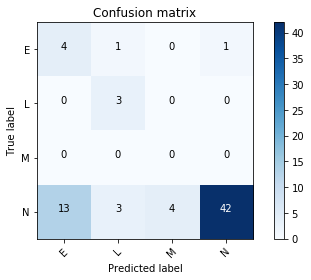

prediction error of fold  1  :  0.704225352112676
Confusion matrix, without normalization


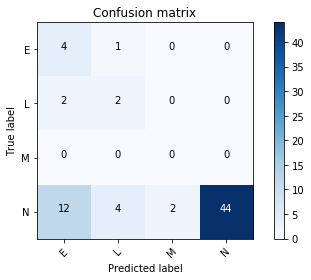

prediction error of fold  2  :  0.6197183098591549
Confusion matrix, without normalization


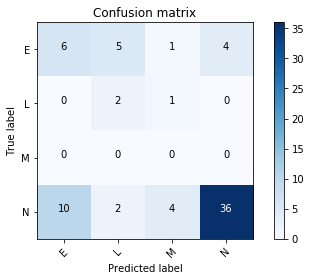

prediction error of fold  3  :  0.6901408450704225
Confusion matrix, without normalization


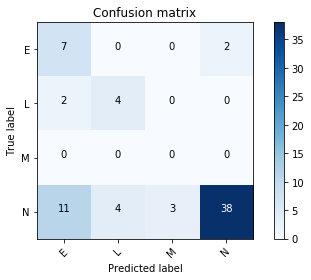

prediction error of fold  4  :  0.6619718309859155
Confusion matrix, without normalization


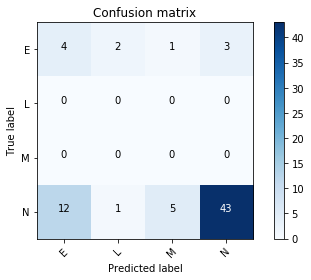

In [93]:
for i in range(5):
    test_data=folds_data[i]
    test_labels=folds_labels[i]
    train_number=np.delete(fold_number,i,axis=0)
    train_data=np.concatenate((folds_data[train_number[0]],folds_data[train_number[1]],folds_data[train_number[2]],folds_data[train_number[3]]))
    train_labels=np.concatenate((folds_labels[train_number[0]],folds_labels[train_number[1]],folds_labels[train_number[2]],folds_labels[train_number[3]]))

    RFClassifier=RandomForestClassifier(n_estimators=200,max_depth=30,max_features='auto')
    RFClassifier.fit(train_data,train_labels)
    predictY=RFClassifier.predict(test_data)
    plt.title("Measured versus Predicted")
    #plt.scatter(test_labels,list(predictY),c='b')
    #plt.plot(test_labels,test_labels,c='r')
    plt.xlabel("real value")
    plt.ylabel("predict value")
    #print(myLS.getWLS())
    con_mat=confusion_matrix(predictY,test_labels)
    

    score=precision_score(y_pred=predictY,y_true=test_labels,average='micro')

    print("prediction error of fold ",i," : ",precision_score(y_pred=predictY,y_true=test_labels,average='micro'))
    plot_confusion_matrix(con_mat,classes=['E','L','M','N'],normalize=False)
    plt.show()
    precisionArr.append(score)

In [94]:
test_labels

array(['N', 'E', 'N', 'N', 'N', 'N', 'N', 'M', 'N', 'N', 'E', 'M', 'E',
       'E', 'E', 'M', 'N', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'E',
       'L', 'E', 'N', 'N', 'N', 'N', 'N', 'M', 'M', 'N', 'N', 'N', 'N',
       'E', 'N', 'E', 'N', 'N', 'N', 'M', 'N', 'N', 'N', 'N', 'N', 'E',
       'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'E', 'N', 'E', 'E', 'N',
       'E', 'N', 'N', 'N', 'E', 'N'], dtype='<U1')

In [95]:
print("average precision:",np.mean(precisionArr))

average precision: 0.6535211267605634


by training the best parameters, the output became better, but just improve a little

## 1-4 Gaussian Naive Bayes Classifier by Changlin Jiang

### Discussion
The image-based dataset is likely to be iid,so naive bayes classifier may work.Implement gaussian naive bayes classifier to the dataset and use cross validation to check the accuracy:

### PCA with error<0.1 (k=59)

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [102]:
U_k=U_gray[:,:109]
WBC_gray_telda=np.mat(U_k.T)*np.mat(WBC_normalized_gray)

In [103]:
clf = GaussianNB()
data_gaussian=WBC_gray_telda.T
scores_gaussian = cross_val_score(clf, data_gaussian, label_arr, cv=5)
print("Gaussian naive bayes classifier:")
print("Cross validation scores=",scores_gaussian,",Mean accuragy=",np.mean(scores_gaussian))

Gaussian naive bayes classifier:
Cross validation scores= [0.45205479 0.51388889 0.5915493  0.62857143 0.65217391] ,Mean accuragy= 0.5676476641597983


In [104]:
training_data=WBC_gray_telda[:,:300]
training_label=label_arr[:300]
test_data=WBC_gray_telda[:,300:]
test_label=label_arr[300:]
clf.fit(training_data.T,training_label)
labels_derived=clf.predict(test_data.T)
error=0
for i in range(len(test_label)):
    if test_label[i]!=labels_derived[i]:
        error+=1
accuracy=1-error/len(test_label)
print("0-1 Loss=",error," Accuracy=",accuracy)

0-1 Loss= 10  Accuracy= 0.8181818181818181


In [105]:
conf_mat=confusion_matrix(test_label, labels_derived)
print(conf_mat)

[[44  1  0  2]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 6  0  0  1]]


Confusion matrix, without normalization
[[44  1  0  2]
 [ 0  0  0  0]
 [ 1  0  0  0]
 [ 6  0  0  1]]


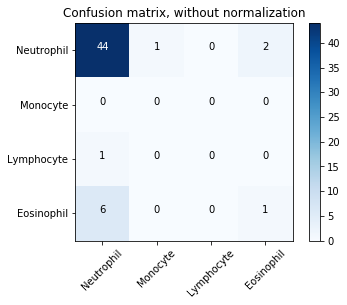

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
WBC_classes = {'Neutrophil': 0, 'Monocyte': 1, 'Lymphocyte': 2, 'Eosinophil': 3}
       
plt.figure()
plot_confusion_matrix(conf_mat, classes = list(map(lambda x:x[0], sorted(WBC_classes.items(), key = lambda t:t[1]))),
                      title='Confusion matrix, without normalization')

The result shows that using gaussian naive bayes classifier maybe not a good idea.Possible reason is that the data maybe not gaussian distributed or non-linear model.

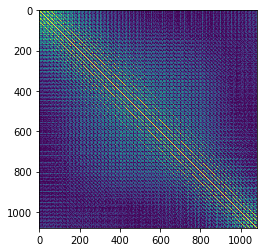

In [108]:
WBC_cov_mat = np.cov(WBC_normalized_gray[:, :].astype(np.float64))
#WBC_cov_mat = WBC_normalized_gray[:, 0][np.newaxis].astype(np.float64).T.dot(WBC_normalized_gray[:, 0][np.newaxis])
#WBC_cov_mat = np.cov(WBC_normalized_gray)
#print(WBC_cov_mat)
img = cv2.convertScaleAbs(WBC_cov_mat*100000)
img = cv2.resize(img, (0, 0), fx=0.3, fy=0.3)
plt.imshow(img)
plt.show()

In [109]:
WBC_normalized_gray[:, 0][np.newaxis].astype(np.float64).T

array([[-0.06919515],
       [-0.06414242],
       [-0.04998645],
       ...,
       [-0.0613414 ],
       [-0.04778742],
       [-0.02465501]])

# 2. Regression Problem
#### Dataset Description:  
The dataset includes 9358 data samples of responses from 5 metal oxide chemical sensors embedded in an Air Quality Monitoring Device, recorded along with hours. The device was located on the field in a significantly polluted area in Italy. The data was collected to estimate benzene concentration with the response from the previously mentioned sensors, which are originally designed to monitor non-benzene substance concentration(i.e. there maybe a potential relationship between the concentration of benzene and the 5 kinds of non-benzene substance.).Consequently, the labels should be the true values of benzene concentration.  
The dataset is provided in S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia, On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario, Sensors and Actuators B: Chemical, Volume 129, Issue 2, 22 February 2008, Pages 750-757, ISSN 0925-4005.  

## 2-1 pre-processing and LS Solution Approach by Changlin Jiang
#### Libraries and dataset importing

In [176]:
# import libraries
import csv
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn import linear_model
import math, time

In [111]:
# read dataset from csv file
with open('air-quality\\AirQualityUCI.csv') as csv_file:
    csv_reader=csv.reader(csv_file, delimiter=',')
    date,time,CO_true,CO_measured,NMHC_true,C6H6_true,NMHC_measured,NOx_true,NOx_measured,NO2_true,NO2_measured,O3_measured,temp,RH,AH=[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)]
    line_count=0
    for row in csv_reader:
        if row[0]=="":
            break;
        if(line_count!=0):
            date[line_count-1],time[line_count-1],CO_true[line_count-1],CO_measured[line_count-1],NMHC_true[line_count-1],C6H6_true[line_count-1],NMHC_measured[line_count-1],NOx_true[line_count-1],NOx_measured[line_count-1],NO2_true[line_count-1],NO2_measured[line_count-1],O3_measured[line_count-1],temp[line_count-1],RH[line_count-1],AH[line_count-1]=row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14]
        line_count+=1

#### Data Cleaning
The missing values in the dataset was tagged with -200. To clean the dataset, the missing values are filled with the mean of the dimension.

In [112]:
# clean the data and label by replacing invalid value with mean
def clean_replace(data,labels):
    # clean the data
    m,n=np.shape(data)
    mean=[0 for i in range(m)]
    for i in range(m):
        sum=0
        count=0
        for j in range(n):
            if(data[i,j]>=0):
                sum+=data[i,j]
                count+=1
        mean[i]=sum/count
    for i in range(m):
        for j in range(n):
            if data[i,j]<0:
                data[i,j]=mean[i]

    # clean the label
    labels=np.array(labels).astype(np.float64)
    sum=0
    count=0
    for i in range(n):
        if labels[i]>=0:
            sum+=labels[i]
            count+=1
    mean=sum/count
    for i in range(n):
        if labels[i]<0:
            labels[i]=mean
    return data,labels

#### LS solution implementation

In [113]:
# implement LS solution
def ls_solution(data,labels):
    m,n=np.shape(data)
    data_hat=np.row_stack((data,[1 for i in range(n)])).T.astype(np.float64)
    w=la.inv(data_hat.T*data_hat)*data_hat.T*labels.T
    return w

#### Cross Validation Implementation

In [201]:
# Build cross validation function, return regression error for each test and derived labels
def cross_validation(data,labels,k:int):
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    
    for i in range(k):
        test_data=fold[i][:m,:].astype(np.float64)
        test_labels = fold[i][m,:]
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        w=ls_solution(training_data[:m,:],training_data[m,:])
        test_data_hat=np.row_stack((test_data,np.mat([1 for x in range(ni)])))
        y=test_data_hat.T*w
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
        else:
            labels_derived[i*a:]=y
        #print(labels_derived)
        reg_error[i]=la.norm(y.T-test_labels,2)
    overall_error=np.mean(reg_error)
    return reg_error,labels_derived,overall_error

#### Overall process implementation
The pipeline implemented is as below:  
- Data importing:  
Import data from csv file and save each dimension into a individual list.
- Data cleaning:
Fill all the missing values in data with the mean of the dimension.
- Algorithm implement:
Implement LS solution to learn the dataset.
- Algorithm evaluation:
Build K-folds cross validation to compute the regression error of the algorithm
- Parameter determination:
Run K-folds cross validation with K in a linear array to find the best K for this certain dataset.

In [198]:
# Define overall process function to show the results
def standardize(X):
    X_centered = X - np.mean(X,axis=1)
    X_std = 1
    X_std = np.std(X_centered, axis = 1)
    return X_centered/X_std
def ls_regression(data,labels):
    m,n=np.shape(np.mat(data))
    if m>1:
        data=np.row_stack(data)
    data=np.mat(data).astype(np.float64)
    data,labels=clean_replace(data,labels)
    data = standardize(data)
    labels = standardize(labels[np.newaxis])
    # Implement LS regression nand cross validation to find the best K
    k=[2,3,4,5,6,7,8,9,10]
    overall_error=[0 for i in range(9)]
    for i in range(9):
        overall_error[i]=cross_validation(data,labels,k[i])[2]
    # Plot the K-Error plot to show the best K
    plt.figure(1)
    plt.plot(k,overall_error)
    plt.title('K-Error Plot')
    print("The best K is ",k[overall_error.index(min(overall_error))])
    # Plot the regression result derived by the best K in a predicted-versus-measured scatter plot
    reg_error,labels_derived,overall_error=cross_validation(data,labels,k[overall_error.index(min(overall_error))])
    labels_derived=np.array(labels_derived).reshape(-1,1)
    labels=np.array(labels).reshape(1,-1).T
    plt.figure(2)
    plt.scatter(labels,labels_derived,color='b')
    ymax=max([max(labels),max(labels_derived)])
    plt.plot([0,max(labels)],[0,max(labels)], color='r', linewidth=1, alpha=0.6)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Measured Labels')
    plt.title('Overall L2-Loss Regression Error={}'.format(overall_error))

The best K is  10
---%s processing time:  1.1588702201843262


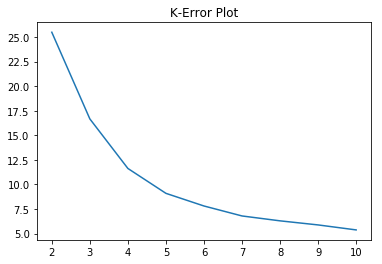

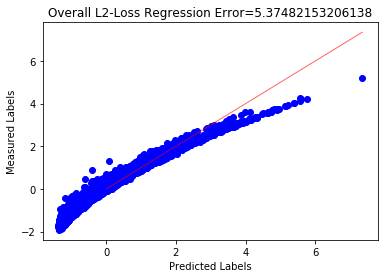

In [202]:
start_time = time.time()
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=C6H6_true
ls_regression(data,labels)
print('---%s processing time: ', time.time()-start_time )

compare to sklearn least regression
The best K is  10
--- processing time: 1.1520 seconds --- 


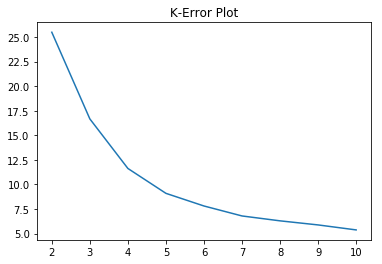

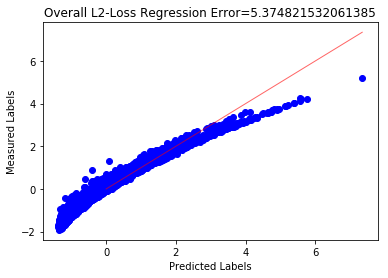

In [193]:
print("compare to sklearn least regression")
from sklearn import linear_model

# Use sklearn ls model inside the cross_validation implementation
def standardize(X):
    X_centered = X - np.mean(X,axis=1)
    X_std = 1
    X_std = np.std(X_centered, axis = 1)
    return X_centered/X_std
def cross_validation(data,labels,k:int):
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    
    for i in range(k):
        test_data=fold[i][:m,:].astype(np.float64)
        test_labels = fold[i][m,:]
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        reg=linear_model.LinearRegression()
        reg.fit(training_data[:m,:].T,training_data[m].T)
        y=reg.predict(test_data.T)
        #print(y.shape)
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
        else:
            labels_derived[i*a:]=y
        reg_error[i]=la.norm(y.T-test_labels,2)
    overall_error=np.mean(reg_error)
    return reg_error,labels_derived,overall_error
start_time = time.time()
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=C6H6_true
ls_regression(data,labels)
print('--- processing time: %5.4f seconds --- ' % (time.time()-start_time))
#data_clean, labels_clean = clean_replace(np.array(data).astype(np.float64), np.asarray(list(map(float, labels))))
#data_clean=np.mat(data_clean)
#data_normalized_clean, labels_normalized_clean = standardize(data_clean), standardize(labels_clean[np.newaxis])
#reg=linear_model.LinearRegression()
#reg.fit(data_normalized_clean.T,labels_normalized_clean[0])
#y=reg.predict(clean_data.T)
#print ("error:",np.linalg.norm(labels-y))
#plt.scatter(labels,y)
#plt.show()

## 2-2 random forest approach by Chaoji Zuo

When I started solving this problem, I did not use any other optimazation methods, I just try to put all the cleaned data into the Random Forest Regression model and did not know clearly what would I get.

And the result really surprise me, the error is really small and random forest looks like a perfect solution for this dataset.

In [181]:
from sklearn.ensemble import RandomForestRegressor
data=np.array(data).astype(np.float64)
data,labels=clean_replace(data,labels)
clean_data=np.array(data)
X_train, y_train = clean_data.T[:6000],labels[:6000]
X_test,y_test=clean_data.T[6000:],labels[6000:]

In [182]:
regr=RandomForestRegressor()
regr.fit(clean_data.T,labels)

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

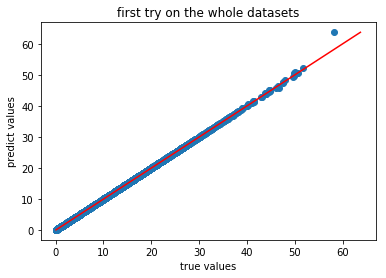

2-norm error: 5.9312899102977505
R^2 score of predict values: 0.9999294905887524


In [183]:
data=np.array(data).astype(np.float64)
clean_data=np.array(data)
labels=np.array(labels).astype(np.float64)
res=regr.predict(clean_data.T)

plt.scatter(res,labels)
plt.plot([min(labels),max(labels)],[min(labels),max(labels)],c='r')
plt.title("first try on the whole datasets")
plt.xlabel("true values")
plt.ylabel("predict values")
plt.show()
print("2-norm error:",np.linalg.norm(res-labels))
print("R^2 score of predict values:",regr.score(clean_data.T,labels))

However, this may be just because I use the training data to do the test. And it may have some kind of over-fitting so I then leave some test data and train the model using the training data.

And It still get a great performance.

F:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


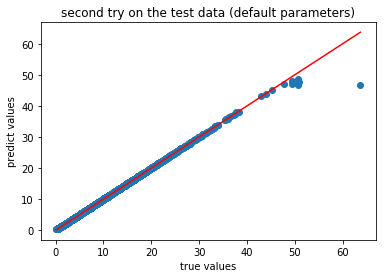

2-norm error: 18.1862379670076
R^2 score of predict values: 0.9981000365393687


In [184]:
regr=RandomForestRegressor()
regr.fit(X_train,y_train)
res=regr.predict(X_test)

plt.scatter(y_test,res)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='r')
plt.title("second try on the test data (default parameters)")
plt.xlabel("true values")
plt.ylabel("predict values")
plt.show()
print("2-norm error:",np.linalg.norm(res-y_test))
print("R^2 score of predict values:",regr.score(X_test,y_test))

So I think this model doesn't have a over-fitting problem.

It is a very sutiable model to this dataset.

Since I just use the default parameters, I think maybe I can get a even better result by using the cross validation to train the best parameters.

In [185]:
from sklearn.model_selection import GridSearchCV

X_train, y_train = clean_data.T[:6000],labels[:6000]

rfr = RandomForestRegressor()
tuned_parameters = [{'min_samples_leaf':[1,2,3], 'n_estimators':[10,20,200]}]

clf = GridSearchCV(estimator=rfr,param_grid=tuned_parameters, cv=5, n_jobs=1)

clf.fit(X_train, y_train)
print('Best parameters:')
print(clf.best_params_)

Best parameters:
{'n_estimators': 200, 'min_samples_leaf': 1}


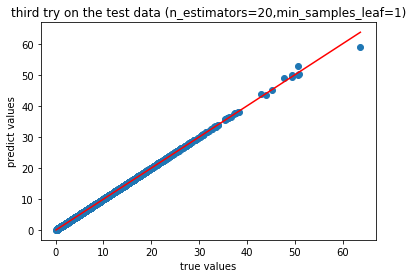

2-norm error: 5.654982046963494
R^2 score of predict values: 0.999816294579594


In [186]:
regr=RandomForestRegressor(n_estimators=20,min_samples_leaf=1)
regr.fit(X_test,y_test)
res=regr.predict(X_test)

plt.scatter(y_test,res)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='r')
plt.title("third try on the test data (n_estimators=20,min_samples_leaf=1)")
plt.xlabel("true values")
plt.ylabel("predict values")
plt.show()

print("2-norm error:",np.linalg.norm(res-y_test))
print("R^2 score of predict values:",regr.score(X_test,y_test))

I really got a better solution using the best parameters of "min_samples_leaf" and "n_estimators".

But the progress was not very significant, because the former soultion is great enough.

### model review

In [60]:
print("shape of decision path:",regr.decision_path(X_test)[0].toarray().shape)

shape of decision path: (3357, 15296)


In [61]:
from sklearn.tree import export_graphviz
estimator = regr.estimators_[0]
export_graphviz(estimator,feature_names=['CO_measured','NMHC_measured','NOx_measured','NO2_measured','O3_measured','temp','RH','AH'],out_file='tree.dot')

In [204]:
print("feature importances:")
print(regr.feature_importances_)

feature importances:
[6.26310219e-04 9.98987520e-01 8.33019241e-05 1.71472835e-04
 1.97142558e-05 2.19122740e-05 6.94275857e-05 2.03408991e-05]


Data without the most important quantity (NMHC concentration)
The best K is  10


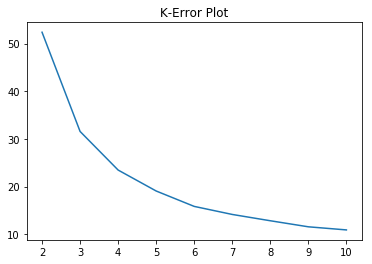

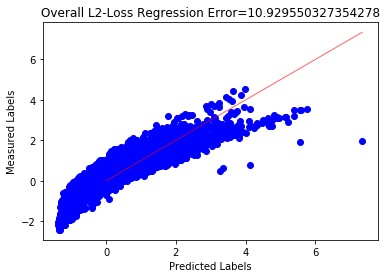

In [206]:
def cross_validation(data,labels,k:int):
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    
    for i in range(k):
        test_data=fold[i][:m,:].astype(np.float64)
        test_labels = fold[i][m,:]
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        w=ls_solution(training_data[:m,:],training_data[m,:])
        test_data_hat=np.row_stack((test_data,np.mat([1 for x in range(ni)])))
        y=test_data_hat.T*w
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
        else:
            labels_derived[i*a:]=y
        #print(labels_derived)
        reg_error[i]=la.norm(y.T-test_labels,2)
    overall_error=np.mean(reg_error)
    return reg_error,labels_derived,overall_error

data1=(CO_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
print('Data without the most important quantity (NMHC concentration)')
ls_regression(data1, labels)

## 2-3 lasso regression approach by Shuyu Chen

The following implementation is LASSO regression on the AirQuality dataset. Least square estimation The motivation is to compare the 

best alpha is 0.0004, with the minimum error of 8.0676


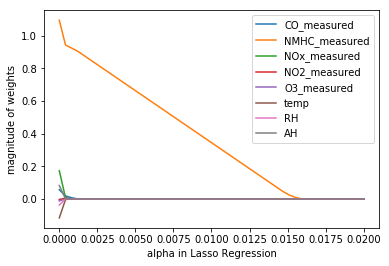

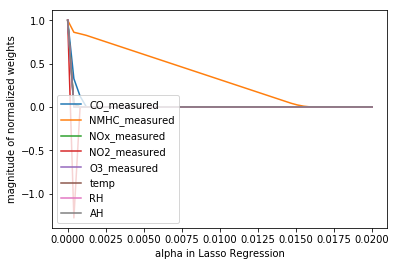

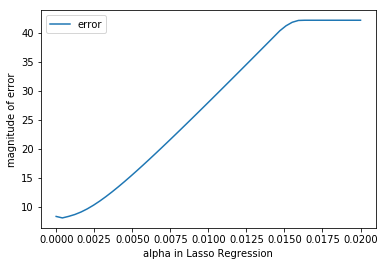

In [207]:
num_lassoSamples = 50

def standardize(X):
    #print(X.shape)
    #print(np.mean(X,axis=1)[:, np.newaxis].shape)
    X_centered = X - np.mean(X,axis=1)[:, np.newaxis]
    X_std = 1
    X_std = np.std(X_centered, axis = 1)[:, np.newaxis]
    return X_centered/X_std

# Build cross validation function, return regression error for each test and derived labels
def cross_validation(data,labels,k:int,alpha):
    
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    #print(data_with_labels.shape)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    w_arr = []
    for i in range(k):
        test_data=fold[i].astype(np.float64)
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        reg = linear_model.LassoLars(alpha = alpha)
        #reg.fit(np.vstack((training_data[:m, :], np.ones((1, training_data.shape[1])))).T, training_data[m].T)
        #print(np.vstack((training_data[:m, :], np.ones((1, training_data.shape[1])))).T.shape)
        #print(training_data[:m,:].shape, training_data[m].T.shape)
        reg.fit(training_data[:m, :].T, training_data[m].T)
        w = reg.coef_[np.newaxis].T
        #print(w)
        #test_data_hat=np.row_stack((test_data[:m,:],np.mat([1 for x in range(ni)])))
        #print(w.shape)
        #y=test_data[:m,:].T.dot(w)
        y = test_data[:m,:].T.dot(w)
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
            reg_error[i]=la.norm(y.T-np.asarray(labels)[i*a:(i+1)*a].astype(np.float64),2)
        else:
            labels_derived[i*a:]=y
            #print(y.T-np.asarray(labels)[i*a:].astype(np.float64))
            #print(y)
            #print(np.asarray(labels)[i*a:].astype(np.float64))
            reg_error[i]=la.norm(y.T-np.asarray(labels)[i*a:].astype(np.float64),2)
        w_arr.append(w.T.tolist()[0])
    #print('progressing')
    w_arr = np.asarray(w_arr)
    
    w_arr_avg = np.mean(w_arr, axis = 0)
    overall_error=np.mean(reg_error)
    return reg_error,labels_derived,overall_error, w_arr_avg


data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
data = np.asarray(data).astype(np.float64).T
targets = np.asarray(list(map(float, targets)))
index_data = [i for i, e in enumerate(data) if str(e[0])!='nan' and e[0]>0]
#print(targets)
data_cleaned = data[index_data]
targets_cleaned = targets[index_data]
data_standardized_cleaned = standardize(np.asarray(data_cleaned).T)
targets_standardized_cleaned = standardize(targets_cleaned[np.newaxis].astype(np.float64))




lasso_err_arr = []
error_arr = []
weights_list = []
for a in np.linspace(0, 0.015, num=num_lassoSamples):
    lasso_err, targets_est, overall_error, weights = cross_validation(data_standardized_cleaned, 
                                                                      targets_standardized_cleaned[0], 5, a)
    lasso_err_arr.append(lasso_err)
    error_arr.append(overall_error)
    weights_list.append(weights)

print('best alpha is %5.4f, with the minimum error of %5.4f' 
      % (np.linspace(0, 0.02, num = num_lassoSamples)[np.argmin(error_arr)], min(error_arr)))

#num_lassoSamples = 5
#data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
plt.figure()
weights_plot = np.vstack(weights_list)
plt.plot(np.linspace(0, 0.02, num=num_lassoSamples), weights_plot)
plt.xlabel('alpha in Lasso Regression')
plt.ylabel('magnitude of weights')
plt.legend(['CO_measured','NMHC_measured','NOx_measured','NO2_measured','O3_measured','temp','RH','AH'])

plt.figure()
weights_plot = weights_plot/weights_plot[0]
plt.plot(np.linspace(0, 0.02, num=num_lassoSamples), weights_plot)
plt.xlabel('alpha in Lasso Regression')
plt.ylabel('magnitude of normalized weights')

plt.legend(['CO_measured','NMHC_measured','NOx_measured','NO2_measured','O3_measured','temp','RH','AH'])
plt.show()

plt.figure()
plt.plot(np.linspace(0, 0.02, num=num_lassoSamples), error_arr)
plt.xlabel('alpha in Lasso Regression')
plt.ylabel('magnitude of error')

plt.legend(['error'])
plt.show()

#data_regularized_cleaned = np.asarray([x for x in data_regularized if str(x[0])!='nan'])

#lasso_err, targets_est, overall_error, weights = cross_validation(data_regularized_cleaned.T, targets_cleaned, 5, 0.01)

    


## 2-4 further discussion:
At the start of coding this algorithm, there was a great issue. The dataset was provided by UCI, which didn't tag the labels dimension in all the 14 dimensions. Picking the right attribute took a long period of time. The process was as below.  
Firstly, we assumed UCI just provided this dataset for free-researching, i.e. there was no explicit attribute in all the attributes so that we could pick any one by our requirement to check our algorithm freely.  
Our first pick was picking the true value of CO as the labels attribute and estimate it with the responses from the 5 sensors.Firstly we directly plotted a true-versus-measured plot of CO concentration to find out if it fitted linear model.

Text(0.5, 1.0, 'CO_True VS CO_Measured')

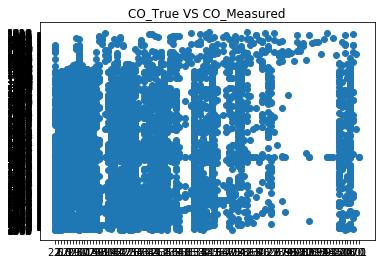

In [208]:
plt.scatter(CO_true,CO_measured)
plt.title('CO_True VS CO_Measured')

It can be indicated from the plot that the model is totally non-linear.The response of the sensor is likely to be random when the true concentration of CO is exactly at some certain value, plotted as vertical straight-line-like shapes in the scatter plot.  
That was the reason why we decided to treat the problem as random model, and directly implement LS solution to find out one answer:
Is there any potential relationships between the responses from the 5 sensors so that we can input all of them to get a better result on when measuring concentration of one certain kind of the substance? That is to say,if we input all the 5 measured attribute into regression algorithm, can we get a lower regression error to the true CO concentration than only inputting the measured CO concentration?  
To find out the answer, firstly we put only the measured CO concentration into LS regression algorithm to get the error:

The best K is  10


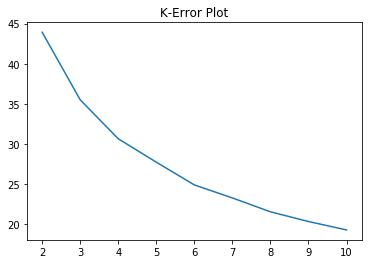

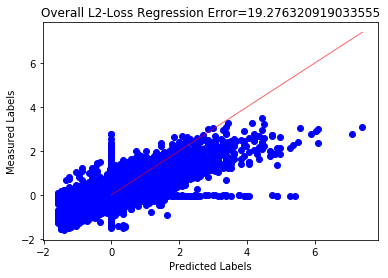

In [210]:
def standardize(X):
    #print(X.shape)
    #print(np.mean(X,axis=1)[:, np.newaxis].shape)
    X_centered = X - np.mean(X)
    X_std = 1
    X_std = np.std(X_centered)
    return X_centered/X_std
def cross_validation(data,labels,k:int):
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    
    for i in range(k):
        test_data=fold[i][:m,:].astype(np.float64)
        test_labels = fold[i][m,:]
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        w=ls_solution(training_data[:m,:],training_data[m,:])
        test_data_hat=np.row_stack((test_data,np.mat([1 for x in range(ni)])))
        y=test_data_hat.T*w
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
        else:
            labels_derived[i*a:]=y
        #print(labels_derived)
        reg_error[i]=la.norm(y.T-test_labels,2)
    overall_error=np.mean(reg_error)
    return reg_error,labels_derived,overall_error

ls_regression(CO_measured,CO_true)

Then we implemented LS regression with input dataset of all the 5 sensors responses, the result was:

In [ ]:
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=CO_true
ls_regression(data,labels)

It can be indicated by comparing the two L2-Loss that there is no enhancement by adding more attributes to the input.It seems hard to continue using the same attribute as labels.  
Finally we directly read the paper cited on the UCL dataset page and found out that the purpose of the collection of this dataset was to estimate the potential of true benzene concentration and the responses of sensors. By setting correct attribute on such data and labels we finally got the above results.

# 3. Cluster - black friday sales
## dataset description
"Dataset of 550 000 observations about the black Friday in a retail store, it contains different kinds of variables either numerical or categorical. It contains missing values."

In [214]:
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [215]:
df_allData=pd.read_csv(os.path.join('blackfriday', 'BlackFriday.csv'))
print(df_allData.sample(n=5))

        User_ID Product_ID Gender    Age  Occupation City_Category  \
184837  1004490  P00245642      M  36-45           5             B   
262408  1004387  P00043542      F  18-25           4             B   
36181   1005574  P00124842      M  26-35           0             B   
11647   1001750  P00350942      M  51-55           5             B   
67777   1004377  P00030842      M  26-35           0             C   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
184837                          1               0                   5   
262408                          0               0                   8   
36181                          4+               0                  11   
11647                           0               0                   3   
67777                           1               1                   1   

        Product_Category_2  Product_Category_3  Purchase  
184837                11.0                12.0      7017  
262408                

raw data has 12 columns and there are a lot of missing values in "Product_Category_2" and "Product_Category_3". Which means some of the product whould just have one category.

## 3-1 data pre-processing by Chaoji Zuo


In our opinion, we think our model would do cluster on different people, so our key is people.

But the dataset includes different records of one-single people. So at the beginning we use gruopby to get each people's whole records. 

Then we try to get the mode of each one's "Product_Category_1" to represent the main product category and get the mean of one people's whole "Purchase" as a feature of "average purchase". (We are not sure weather this is a good way buy we have to do this because we cannot keep all the data to train)

What's more, we change the "Gender" attribute to 0-1 attribute.

In [216]:
groupByUserData=df_allData.groupby(['User_ID'])

times=df_allData['User_ID'].value_counts()
times=times.sort_index()

#get the mean
meanData=groupByUserData.mean()

#get the mode
modeData=groupByUserData.agg(lambda x: stats.mode(x)[0][0])

mean_mode_data={'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],'Stay_In_Current_City_Years':modeData['Stay_In_Current_City_Years']}
mean_mode_data=pd.DataFrame(mean_mode_data)
mean_mode_data['times']=times
mean_mode_data['Gender_M']=pd.get_dummies(mean_mode_data['Gender'])['M']
mean_mode_data=mean_mode_data.drop(['Gender'],axis=1)
mean_mode_data['Purchase']=meanData['Purchase']

print (mean_mode_data.sample(5))

F:\Anaconda\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


           Age City_Category  Marital_Status  Occupation  Product_CateGory_1  \
User_ID                                                                        
1002450  46-50             C               0          16                   8   
1005068  36-45             C               0           7                   8   
1004704  18-25             C               0          20                   1   
1001080    55+             C               1           7                  11   
1005394  18-25             A               0           0                   5   

        Stay_In_Current_City_Years  times  Gender_M     Purchase  
User_ID                                                           
1002450                          1     13         1  8076.538462  
1005068                          2     36         1  8111.250000  
1004704                          1    175         1  6392.868571  
1001080                          1     30         1  9002.400000  
1005394                          2   

## feature extraction

This is the hardest part of our cluster project.

There are two key problems we have to face:

##### 1. **how to handle the discrete attributes?**
    
    There are a lot of disordered discrete attributes in our data, likes "Marital_Status", "Gender" and "Product_Category_1", we cannot just simplely calculate their euclidean distance. We try to take them as continuous variables and apply several cluster algorithms on them but we just get a bad output which looks no special meanning.

##### 2. **how to evaluate our feature extraction performance?**

    Since we have so many choices of extracting the features and we do not know how to assign the weights on these feautres and this is a cluster problem, we had not a clearly mind of have to evaluate our work when we doing the feature extraction. And it is unrealistic to try all the choices and train them then evaluate the final models. The best solution is that we can find some explainable output of our feature extraction.
    
#### deal with discrete attributes

To solve the key problems 1, we came up with ideas.

1. do one-hot encoding on the discrete attributes

1. use k-modes or k-prototype model

1. drop those discrete attributes

But their would raise some new problems if we use these solutions:

    one-hot encoding would make the features very sparse.
    
    It is not easy to combine the VDM distance and Minkowski distance together.
    
    Some discrete features may be very important like occupation but it would have a lot of possible value.
    
#### deal with evaluation

We do not find a good way to solve this problem, we just living with it, but we still did some tries. Likes using the average purchase to evaluate the cluster output. And we use Calinski-Harabasz score and Value Difference Metrix to evalue our final clusters.

###  other data pre-processing before training

Since we have features of different units, we must do the data standardization and assign different weights to different features.

We choose min-max standardization and assign the weights by feeling.

## 3-1 specific approach 1 by Chaoji: k-modes

I try to use the k-modes only on the categorical values to train a model, then use one-hot encoidng data to calculate the jaccard distance and euclidean distance inside each cluster.

In [ ]:
from kmodes.kmodes import KModes

In [217]:
X=pd.DataFrame({'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],"Stay_In_Current_City_Years":modeData["Stay_In_Current_City_Years"]})

one_hot_city=pd.get_dummies(mean_mode_data['City_Category'])
one_hot_age=pd.get_dummies(mean_mode_data['Age'])
one_hot_occupation=pd.get_dummies(mean_mode_data['Occupation'])
one_hot_years=pd.get_dummies(mean_mode_data['Stay_In_Current_City_Years'])
one_hot_product=pd.get_dummies(mean_mode_data['Product_CateGory_1'])
XX=pd.concat([one_hot_age,one_hot_city,one_hot_occupation,one_hot_years,one_hot_product],axis=1)
XX['Gender_M']=mean_mode_data['Gender_M']
XX['Marital_Status']=mean_mode_data['Marital_Status']

print ("categorical data:")
print(X.sample(2))
print("one-hot encoding data:")
print(XX.sample(2))


categorical data:
           Age City_Category Gender  Marital_Status  Occupation  \
User_ID                                                           
1004879  26-35             A      M               0           3   
1002061    55+             B      M               0           1   

         Product_CateGory_1 Stay_In_Current_City_Years  
User_ID                                                 
1004879                   5                          2  
1002061                   8                          0  
one-hot encoding data:
         0-17  18-25  26-35  36-45  46-50  51-55  55+  A  B  C  \
User_ID                                                          
1001892     0      0      1      0      0      0    0  0  0  1   
1003116     0      0      1      0      0      0    0  0  0  1   

              ...        8  10  11  12  13  15  16  18  Gender_M  \
User_ID       ...                                                  
1001892       ...        0   0   0   0   0   0   0   0       

At first, I think the key is finding the best clusters number n, but I don't have ideas about how to evalue the output. I just thought maybe different cluster's average price can reflect some difference.

I try to use jaccard distance and eulicdean distance, but the jaccard distance inside a cluster would alway decrease when n increase.

In [253]:
from sklearn.metrics import jaccard_similarity_score
ecArr=[]
jcArr=[]
jcXArr=[]
for i in range(2,10):
    km=KModes(n_clusters=i)
    y=km.fit_predict(X)
    tempArrjc=[]
    tempArrec=[]
    tempArrjcX=[]
    for j in range(i):
        #print(sum(y==j))
        #print(XX[y==j].mode())
        jcscore=[]
        ecscore=[]
        jcXscore=[]
        for k in XX[y==j].T:
            try:
                #jcscore.append(jaccard_similarity_score(XX.loc[k],XX[y==j].mode().T[0]))
                
                ecscore.append(np.linalg.norm(np.array(XX.loc[k])-np.array(XX[y==j].mode().T[0])))
                
                jcXscore.append(jaccard_similarity_score(list(X.loc[k]),list(X[y==j].mode().T[0])))

            except:
                #print(XX.loc[k].T)
                #print(XX[y==j].mode())
                print(k)
                break;
        #print(np.mean(jcscore))
        #tempArrjc.append(np.mean(jcscore))
        #tempArrec.append(np.mean(ecscore))
        tempArrjcX.append(np.mean(jcXscore))

    print("n_cluster =",i,":",np.mean(tempArrjcX))
    #jcArr.append(np.mean(tempArrjc))
    #ecArr.append(np.mean(tempArrec))
    jcXArr.append(np.mean(tempArrjcX))

n_cluster = 2 : 0.5000269875392017
n_cluster = 3 : 0.5294875041896924
n_cluster = 4 : 0.5534965418820955
n_cluster = 5 : 0.5645384012323531
n_cluster = 6 : 0.5720855312627525
n_cluster = 7 : 0.5890558734522645
n_cluster = 8 : 0.6010495871774273
n_cluster = 9 : 0.6128901655705694


Lack of the ways to evaluate better n, I decide to focus on features more rather than n.

Then I camp up with an idea that I can calculate the eulidean distance between a cluster's mode point and the other point's mode point.

So I do some tries.

In [256]:
XXXX=X.drop(['Marital_Status','Product_CateGory_1','Stay_In_Current_City_Years','Age'],axis=1)
print(XXXX.sample(2))

        Gender  Occupation City_Category
User_ID                                 
1005314      F           0             A
1002289      F           1             C


In [274]:
from sklearn.metrics import jaccard_similarity_score
ecArr=[]
jcArr=[]
jcXArr=[]
for i in range(10,11):
    km=KModes(n_clusters=i)
    y=km.fit_predict(XXXX)
   

In [278]:
dis_jc=[]
dis_ec=[]
for i in range(10):
    dis_jc.append(jaccard_similarity_score(list(XXXX[y==i].mode().T[0]),list(XXXX[y!=i].mode().T[0])))
    
print("average jc distance in selected features:",np.mean(dis_jc))
    
for i in range(10):
    dis_ec.append(np.linalg.norm((np.array(XX[y==i].mode().T[0])-np.array(XX[y!=i].mode().T[0]))))
    
print("average ec distance in all one-hot features:",np.mean(dis_ec))

average jc distance in selected features: 0.5
average ec distance in all one-hot features: 1.3071067811865476


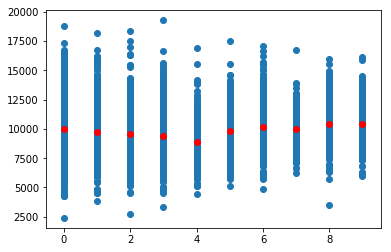

In [276]:
purchase_y=pd.DataFrame({"y":y,"Purchase":mean_mode_data["Purchase"]})
plt.scatter(purchase_y['y'],purchase_y['Purchase'])
for i in range(10):
    plt.scatter(i,purchase_y[purchase_y['y']==i].Purchase.mean(),c='r')

In [287]:
XXXXX=X.drop(['Stay_In_Current_City_Years'],axis=1)
print(XXXXX.sample(2))

        Gender  Occupation    Age City_Category  Marital_Status  \
User_ID                                                           
1004639      M          11  36-45             B               0   
1004422      M           5  26-35             A               1   

         Product_CateGory_1  
User_ID                      
1004639                   5  
1004422                   5  


In [288]:
ecArr=[]
jcArr=[]
jcXArr=[]
for i in range(10,11):
    km=KModes(n_clusters=i)
    y=km.fit_predict(XXXXX)

dis_jc=[]
dis_ec=[]
for i in range(10):
    dis_jc.append(jaccard_similarity_score(list(XXXXX[y==i].mode().T[0]),list(XXXXX[y!=i].mode().T[0])))
    
for i in range(10):
    dis_ec.append(np.linalg.norm((np.array(XX[y==i].mode().T[0])-np.array(XX[y!=i].mode().T[0]))))
    
print("average jc distance in selected features:",np.mean(dis_jc))
print("average ec distance in all one-hot features:",np.mean(dis_ec))

average jc distance in selected features: 0.35
average ec distance in all one-hot features: 1.8432220400206423


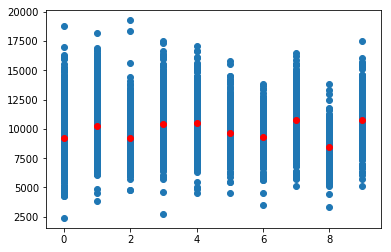

In [284]:
purchase_y=pd.DataFrame({"y":y,"Purchase":mean_mode_data["Purchase"]})
plt.scatter(purchase_y['y'],purchase_y['Purchase'])
for i in range(10):
    plt.scatter(i,purchase_y[purchase_y['y']==i].Purchase.mean(),c='r')

### conclusion

Thought the process is hard, I think I get something surpringly at the end.

I paid too much attentation on the cluster number n and the distance between a cluster but I haven't had a great evaluation way.

But when I campared different features as input to k-modes with the same n, I got some pretty things.

The change in average euclidean distance showed the feature 'Marital_Status' , 'Product_CateGory_1', 'Age' do influence on the whole cluster performance.

What't more, the 'Purchase' would really reflect the performance of cluster in some way.

With this conclusion, it means we can do further work about how different categorial features influence the cluster. The best feature may have the biggest influence on average euclidean distance.

## 3-2 specific approach 2: K-means on continuous features by Shuyu Chen

In [220]:
def recenter_regularize(X):
    #X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_mean = np.mean(X)
    X_centered = X - X_mean
    #X_norm = np.linalg.norm(X_centered)[np.newaxis]
    X_var = np.sqrt(np.var(X_centered))
    X_normalized = X_centered/X_var
    #print(np.var(X_normalized))
    return X_normalized

numGroup = 10

#print(np.array(mean_mode_data.times))
times_arr = np.array(mean_mode_data.times)
times_regularized = recenter_regularize(times_arr)
purchases_regularized = recenter_regularize(np.array(mean_mode_data['Purchase']))

ini_index = np.random.choice(a=range(len(times_arr)), size=len(times_arr), replace=False)

X_2d = np.vstack((np.asarray([times_regularized, purchases_regularized]), list(range(len(times_regularized))))).T
X_2d_group = []
icr = int(np.floor(len(ini_index)/numGroup))
for i in range(numGroup):
    X_2d_group.append(X_2d[i*icr:(i+1)*icr])

isFinished = False
counter = 0
while((not isFinished) and counter <= 200):
    #print("progressing: ")
    isFinished = True
    numDiff=0
    #print(X_2d_group[2])
    X_mean_group = [np.mean(X, axis = 0) for X in X_2d_group]
    #print(len(X_mean_group[0]))
    X_2d_group_new =[[] for h in range(numGroup)]
    for i in range(numGroup):
        
        X_2d_this = X_2d_group[i]
        for j in range(len(X_2d_this)):
           
            sample = X_2d_this[j]
            dist_group = [[] for h in range(numGroup)]
            for k in range(numGroup):
                #print(len(sample))
                #print(X_mean_group[k].shape)
                dist_group[k] = np.linalg.norm(np.asarray(sample)[:2] - np.asarray(X_mean_group[k])[:2])
            
            group = np.argmin(dist_group)
            #print(group)
            if(i != group):
                isFinished = False
                numDiff += 1
            X_2d_group_new[group].append(sample)
    
        #if(len(X_2d_this_new)>0):
        #for k in range(numGroup):
        #    X_2d_group_new[k] = np.vstack(X_2d_group_new[k])
        #else:
        #    X_2d_group_new.append(np.asarray([]))
    #print(numDiff)
    X_2d_group = X_2d_group_new
    if numDiff == 0:
        break
    #print(len(X_2d_group))
    counter+=1

    

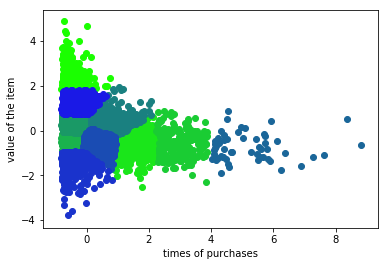

In [221]:
X_2d_group_arr = np.asarray(list(map(np.vstack,X_2d_group)))
plt.figure()
for i in range(numGroup):
    #for j in range(len(X_2d_group_arr[i])):
    plt.scatter(X_2d_group_arr[i][:,0], X_2d_group_arr[i][:,1], color = [0.1, 1-0.1*i, 0.1*i])
        
plt.xlabel('times of purchases')
plt.ylabel('value of the item')
plt.show()




In [223]:
mean_mode_data['Product_CateGory_1'].value_counts()

5     2186
1     2127
8     1320
11     102
3       84
6       25
10      12
2       10
7        6
4        6
12       5
18       3
15       2
13       2
16       1
Name: Product_CateGory_1, dtype: int64

In [222]:
X_2d_group_arr = np.asarray(X_2d_group)
productCategory = np.array(mean_mode_data['Product_CateGory_1'])
cateList = []
for j in range(len(X_2d_group_arr[0])):
    idx = X_2d_group_arr[0][j][-1]
    cateList.append(productCategory[int(idx)])

print('Product Category attributes of the samples in cluster one')
print(cateList)
    

Product Category attributes of the samples in cluster one
[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 6, 7, 10, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 7, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 8, 1, 1, 1, 6, 8, 1, 1, 1, 1, 10, 1, 1, 5, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 10, 1, 1, 1]


### Comparing with sklearn KMeans

comparing KMeans results yield from unnormalized data shows the importance of normalization

In [9]:
from sklearn.cluster import KMeans

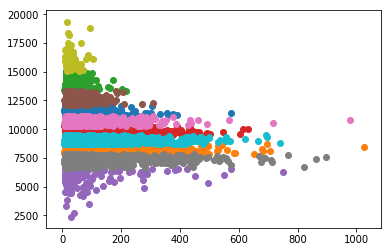

In [10]:
xm=pd.DataFrame({'t':mean_mode_data['times'],'p':mean_mode_data['Purchase']})

km=KMeans(n_clusters=10).fit(xm)

ym=km.labels_
for i in range(10):
    plt.scatter(xm[ym==i]['t'],xm[ym==i]['p'])
from sklearn.preprocessing import normalize

xmn=normalize(xm)
xmn=pd.DataFrame({'t':xmn[:,0],'p':xmn[:,1]})

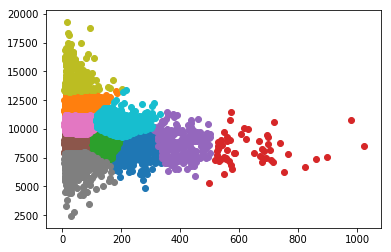

In [28]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(xm)
xmn=scaler.transform(xm)
xmn=pd.DataFrame({'t':xmn[:,0],'p':xmn[:,1]})

kmn=KMeans(n_clusters=10).fit(xmn)
ymn=kmn.labels_

for i in range(10):
    plt.scatter(xm[ymn==i]['t'],xm[ymn==i]['p'])

In [14]:
mnmode=[]
for i in range(10):
    mnmode.append(np.linalg.norm((np.array(XX[ymn==i].mode().T[0])-np.array(XX[ymn!=i].mode().T[0]))))
print(np.mean(mnmode))

1.2846433962579518


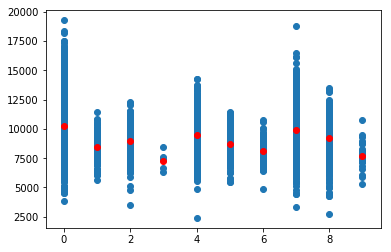

In [15]:
purchase_y=pd.DataFrame({"y":ymn,"Purchase":mean_mode_data["Purchase"]})
plt.scatter(purchase_y['y'],purchase_y['Purchase'])
for i in range(10):
    plt.scatter(i,purchase_y[purchase_y['y']==i].Purchase.mean(),c='r')

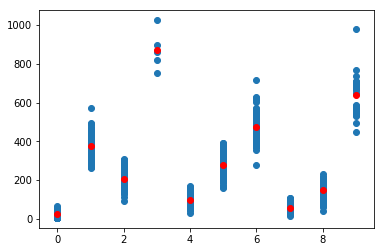

In [16]:
purchase_y=pd.DataFrame({"y":ymn,"Purchase":mean_mode_data["times"]})
plt.scatter(purchase_y['y'],purchase_y['Purchase'])
for i in range(10):
    plt.scatter(i,purchase_y[purchase_y['y']==i].Purchase.mean(),c='r')

## 3-3 Specific Model 3: ROCK Clustering by Changlin Jiang
- After searching relavant paper dealing with discrete features clustering,we decide to implement a algorithm termed ROCK.  
- The main idea is:  
    - Compute the Jaccard score between 2 data points.Input a threshold theta such that if the Jaccard score is larger than the threshold,say these 2 points are neighbors (i.e. they have a Neighbor label which is originally 0 and can be set to 1 if their Jaccard score is larger than the threshold theta.)  
    - Compute the Neighbor label of every 2 data,put them in a Neighbors Matrix A,A[i,j]=1 if point i and j are neighbors,A[i,j]=0 if not.
    - Initialization:If note the number of data points with n,initialize the clusters with n clusters,each cluster includes only one data point.
    - Gooodness:The goodness of 2 clusters $C_i$ and $C_j$ can be determined by: $$goodness=\frac{link(C_i,C_j)}{(n1+n2)^{1+2f(\theta)}-n1^{1+2f(\theta)}-n2^{1+2f(\theta)}}$$In this formula,link(Ci,Cj) is the total number of neighbors of the two clusters $C_i$ and $C_j$,$$f(\theta)=\frac{1-\theta}{1+\theta}$$is the penalty if the size of the cluster has got too many members.
    - Compute goodness of every 2 different clusters,find the pair of clusters with the largest goodness.
    - Process:Merge the two clusters into one clusters and loop the whole process untill converge or number of clusters is smaller than a wanted number.

In [110]:
from sklearn.metrics import jaccard_similarity_score

In [108]:
X=np.array(X)
X0=list(X[:,0])
X2=list(X[:,2])
X3=list(X[:,3])
X6=list(X[:,6])

X0=[0 if x=='M' else 1 for x in X0]

X2=[0 if x=='0-17' else x for x in X2]
X2=[1 if x=='18-25' else x for x in X2]
X2=[2 if x=='26-35' else x for x in X2]
X2=[3 if x=='36-45' else x for x in X2]
X2=[4 if x=='46-50' else x for x in X2]
X2=[5 if x=='51-55' else x for x in X2]
X2=[6 if x=='55+' else x for x in X2]

X3=[0 if x=='A' else x for x in X3]
X3=[1 if x=='B' else x for x in X3]
X3=[2 if x=='C' else x for x in X3]

X6=[0 if x=='0' else x for x in X6]
X6=[1 if x=='1' else x for x in X6]
X6=[2 if x=='2' else x for x in X6]
X6=[3 if x=='3' else x for x in X6]
X6=[4 if x=='4+' else x for x in X6]

X[:,0]=np.array(X0).T
X[:,2]=np.array(X2).T
X[:,3]=np.array(X3).T
X[:,6]=np.array(X6).T

X1=X[:300,:]
print(X1)

[[1 'A' 'F' ... 10 3 2]
 [1 'C' 'M' ... 16 1 4]
 [1 'A' 'M' ... 15 1 3]
 ...
 [1 'C' 'M' ... 7 5 1]
 [1 'B' 'M' ... 0 10 1]
 [1 'B' 'F' ... 0 11 3]]


### Derive neighbors matrix A:

In [111]:
def neighbors_matrix(data,theta):
    m,n=np.shape(data)
    A=np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            if jaccard_similarity_score(np.reshape(list(data[i,:]),-1),np.reshape(list(data[j,:]),-1))>=theta:
                A[i,j]=1
    return A.astype(int)

A=neighbors_matrix(X1,0.5)
print(A)

[[1 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


### Compute the $link(C_i,C_j)$ of $C_i$ and $C_j$

In [112]:
def link(A,c1,c2):
    m,n=np.shape(A)
    sum_=0
    if isinstance(c1,int)==True:
        n1=1
    else:
        n1=len(c1)
    if isinstance(c2,int)==True:
        n2=1
    else:
        n2=len(c2)
    for i in range(n1):
        for j in range(n2):
            if isinstance(c1,int)==True:
                k1=c1
            else:
                k1=c1[i]
            if isinstance(c2,int)==True:
                k2=c2
            else:
                k2=c2[j]
            sum_+=A[k1,k2]
    return sum_

### Compute goodness of $C_i$ and $C_j$

In [113]:
def goodness(A,c1,c2,theta):
    if isinstance(c1,int)==True:
        n1=1
    else:
        n1=len(c1)
    if isinstance(c2,int)==True:
        n2=1
    else:
        n2=len(c2)
    ftheta=(1-theta)/(1+theta)
    if c1==c2:
        gm=0
    else:
        gm=link(A,c1,c2)/((n1+n2)**(1+2*ftheta)-n1**(1+2*ftheta)-n2**(1+2*ftheta))
    return gm

### Find the best pair

In [114]:
def find_best_pair(A,clusters,theta):
    maximum_goodness = 0.0;
    cluster_indexes = [-1, -1];
        
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            gm = goodness(A,clusters[i], clusters[j],theta);
            if (gm > maximum_goodness):
                maximum_goodness = gm;
                cluster_indexes = [i, j]
        
    return cluster_indexes;

In [115]:
def merge(clusters,cluster_indexes):
    if isinstance(clusters[cluster_indexes[0]],int)==True:
        clusters[cluster_indexes[0]]=[clusters[cluster_indexes[0]]]
    if isinstance(clusters[cluster_indexes[1]],int)==True:
        clusters[cluster_indexes[1]]=[clusters[cluster_indexes[1]]]
    clusters[cluster_indexes[0]].extend(clusters[cluster_indexes[1]])
    clusters.pop(cluster_indexes[1])
    
    return clusters

### Process and clustering result

In [116]:
clusters=list([i for i in range(300)])
for i in range(len(clusters)-10):
    new_clusters=merge(clusters,find_best_pair(A,clusters,0.5))
    if len(new_clusters)<=10:
        print("Number of clusters<=10")
        print(clusters)
        break;
    else:
        clusters=new_clusters

Number of clusters<=10
[[0, 5, 33, 48, 67, 138, 197, 215, 244, 276, 292, 96, 115, 190, 196, 241, 266, 10, 36, 87, 103, 128, 149, 172, 178, 192, 210, 225, 238, 245, 263, 60, 11, 30, 54, 105, 108, 208, 271, 153, 186, 201, 212, 81, 82, 131, 148, 187, 198, 65, 37, 295, 296, 21, 40, 216, 35, 205, 222, 230, 254, 132, 219, 165, 24, 127, 141, 49, 74, 28, 221, 224, 58, 91, 177, 195, 202, 159, 213, 255, 118, 209, 110, 1, 16, 97, 114, 247, 289, 13, 116, 117, 125, 139, 170, 176, 181, 184, 251, 274, 293, 63, 84, 249, 281, 8, 43, 104, 168, 229, 156, 261, 99, 182, 38, 70, 143, 158, 258, 14, 218, 283, 122, 175, 226, 257, 267, 80, 161, 223, 252, 278, 256, 18, 55, 188, 107, 185, 240, 231, 2, 19, 50, 242, 269, 234, 272, 135, 83, 102, 206, 57, 140, 204, 207, 106, 236, 250, 166, 211, 248, 89, 160, 220, 298, 285, 92, 12, 77, 130, 277, 62, 79, 112, 297, 46, 262, 291, 26, 151, 253, 286, 34, 51, 120, 232, 275, 287, 6, 39, 90, 137, 243, 259, 200, 61, 235, 101, 88, 270, 44, 214, 123, 154, 157, 7, 203, 134, 53, 2